# synaptic modification "out of graph", via tensorflow session
(somewhat inconvenient, but really not that bad)

In [1]:
import numpy as np
from spikeflow import BPNNModel, IzhikevichNeuronLayer
from spikeflow import Synapse, ComplexSynapseLayer, weights_from_synapses
from spikeflow.drawing_utils.trace_renderers import *

/Applications/Anaconda/anaconda/envs/mlbook/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Create a model layer with 2 neurons in a single layer, with a decaying feed-forward connection to a second layer

In [2]:
model_input_shape = (2,)

neuron_layer_0 = IzhikevichNeuronLayer.layer_from_tuples([
    IzhikevichNeuronLayer.C(a=0.030, b=0.2, c=-65.0, d=6.0, t=30.0, v0=0.0),
    IzhikevichNeuronLayer.C(a=0.035, b=0.2, c=-65.0, d=6.0, t=30.0, v0=0.0),
])

neuron_layer_1 = IzhikevichNeuronLayer.layer_from_tuples([
    IzhikevichNeuronLayer.C(a=0.010, b=0.2, c=-65.0, d=6.0, t=30.0, v0=0.0),
    IzhikevichNeuronLayer.C(a=0.015, b=0.2, c=-65.0, d=6.0, t=30.0, v0=0.0)
])

forward_connection = ComplexSynapseLayer(
    neuron_layer_0, 
    neuron_layer_1, 
    decay = 0.95, 
    #failure_prob = 0.3,
    #post_synaptic_reset_factor = 0.6,
    weights = weights_from_synapses(neuron_layer_0, neuron_layer_1, [
        Synapse(0, 0, 8.0),
        Synapse(1, 0, 8.0),
        Synapse(0, 1, 8.0),
        Synapse(1, 1, 8.0)
    ])
)

model = BPNNModel.compiled_model(model_input_shape, 
                                 [neuron_layer_0, neuron_layer_1], 
                                 [forward_connection])

# Run the model for 2000 timesteps. At t=1500, multiply all weights by 3

In [3]:
traces = []

def end_time_step_callback(i, graph, sess, results):
    traces.append(results)
    
    # part-way through, modify the weights
    if i == 1500:
        
        # Read the weights and printem
        w = sess.run(forward_connection.weights)
        print('MODDING WEIGHTS FROM:\n', w)
        
        # update the weights
        sess.run(forward_connection.weights.assign(w * 3.0))
        
        # Read and print updated weights
        print('...TO:\n', sess.run(forward_connection.weights))
        
        
data = (np.ones(2,)*(7 if i > 1200 else 0) for i in range(0, 2000))
    
model.run_time(data, end_time_step_callback)

MODDING WEIGHTS FROM:
 [[8. 8.]
 [8. 8.]]
...TO:
 [[24. 24.]
 [24. 24.]]


# Extract the data we want and display

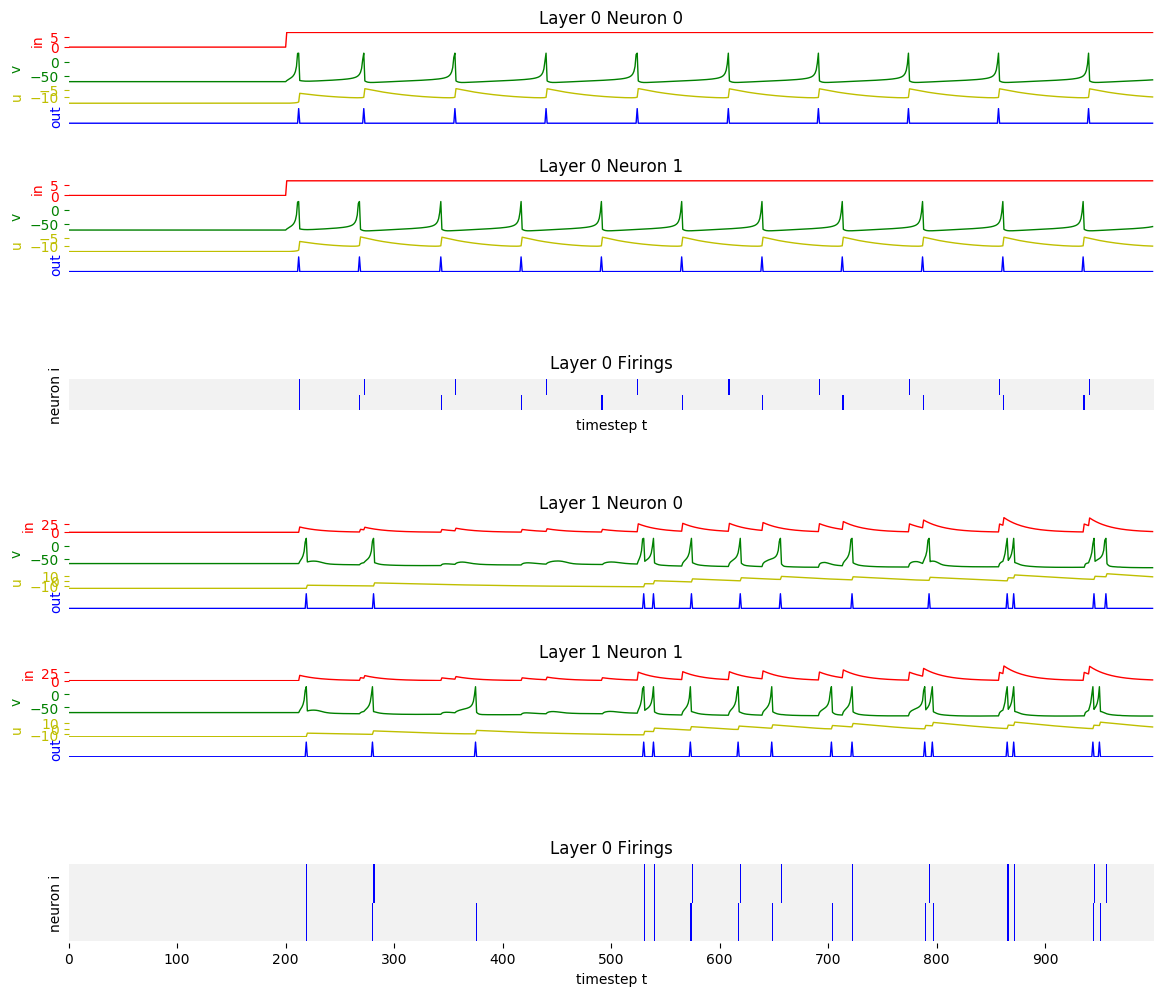

In [4]:
neuron_layer_0_traces = np.array([r[0] for r in traces])
neuron_layer_1_traces = np.array([r[1] for r in traces])

render_figure([IzhikevichNeuronTraceRenderer(neuron_layer_0_traces, 'Layer 0 Neuron'),
               NeuronFiringsRenderer(neuron_layer_0_traces[:,3,:], 30, 'Layer 0 Firings'),
               IzhikevichNeuronTraceRenderer(neuron_layer_1_traces, 'Layer 1 Neuron'), 
               NeuronFiringsRenderer(neuron_layer_1_traces[:,3,:], 100,'Layer 0 Firings')
              ],
              1000, 2000, 100)

You can see that after timestep 1500 (500 as displayed), because of the synaptic increase the second layer neurons fire more often.